# Mobility Attack Numero Dos

Given known locations of a few sensors (at least three), identify the locations of other sensors.

In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import fsolve, least_squares 
from tqdm import tqdm

In [5]:
# Import the simulated sample data.
sensor_df = pd.read_csv('../smol_sim/mules/062.csv')
sensor_df.head()

,sensor ID,norm_secs (secs),time (days)
0,15,11.200029,39423.442618
1,15,11.900031,39423.442626
2,15,12.600032,39423.442634
3,15,13.300034,39423.442642
4,15,14.000036,39423.442650


In [7]:
# Calculate real time to avoid aggressive time-skips.
secs_per_day = 86400
sensor_df['time (secs)'] = (sensor_df['time (days)'] - sensor_df['time (days)'].iloc[0]) * secs_per_day
sensor_df.head()

,sensor ID,norm_secs (secs),time (days),time (secs)
0,15,11.200029,39423.442618,0.000000
1,15,11.900031,39423.442626,0.700002
2,15,12.600032,39423.442634,1.400004
3,15,13.300034,39423.442642,2.100006
4,15,14.000036,39423.442650,2.800007


In [10]:
# Check how many sensors we actually see.
num_sensors = sensor_df['sensor ID'].nunique()
print(num_sensors)

60


In [9]:
# Subsample the time data to take samples that are wider apart in time.
sample_period = 8
smol_df = sensor_df.loc[(sensor_df['time (secs)'].round() % sample_period) == 0]
smol_df.head()

,sensor ID,norm_secs (secs),time (days),time (secs)
0,15,11.200029,39423.442618,0.000000
11,15,18.900049,39423.442707,7.700020
12,34,18.900049,39423.442707,7.700020
13,15,19.600050,39423.442715,8.400022
14,34,19.600050,39423.442715,8.400022


In [33]:
# Construct a matrix that has the time it takes to travel between sensors.
time_diff_lists = [[[] for j in range(num_sensors)] for i in range(num_sensors)]

cap_time = 5 * 60 # Do not consider relations between sensors further than 5 minutes apart.
for i in range(len(smol_df)-1):
    cur_sensor = int(smol_df['sensor ID'].iloc[i])
    cur_time = smol_df['time (secs)'].iloc[i]

    j = 1
    next_sensor = int(smol_df['sensor ID'].iloc[i+j])
    next_time = smol_df['time (secs)'].iloc[i+j]
    time_diff = next_time - cur_time
        
    while time_diff < cap_time:
        time_diff_lists[cur_sensor][next_sensor].append(time_diff)
        time_diff_lists[next_sensor][cur_sensor].append(time_diff)
        
        j += 1
        if i+j >= len(smol_df):
            time_diff = cap_time
        else:
            next_sensor = int(smol_df['sensor ID'].iloc[i+j])
            next_time = smol_df['time (secs)'].iloc[i+j]
            time_diff = next_time - cur_time

In [34]:
print(len(time_diff_lists))
print(len(time_diff_lists[0]))

60
60


In [99]:
ave_time_diffs = np.zeros((num_sensors, num_sensors))
med_time_diffs = np.zeros((num_sensors, num_sensors))
min_time_diffs = np.zeros((num_sensors, num_sensors))
dec_time_diffs = np.zeros((num_sensors, num_sensors))

for i in range(num_sensors):
    for j in range(i, num_sensors):
        times_list = time_diff_lists[i][j]
        if len(times_list) > 0:
            ave_time = sum(times_list) / len(times_list)
            med_time = np.median(times_list)
            min_time = np.min(times_list)
            dec_time = np.percentile(times_list, 10)
            
            ave_time_diffs[[i,j], [j,i]] = ave_time
            med_time_diffs[[i,j], [j,i]] = med_time
            min_time_diffs[[i,j], [j,i]] = min_time
            dec_time_diffs[[i,j], [j,i]] = dec_time
        else:
            ave_time_diffs[[i,j], [j,i]] = -1
            med_time_diffs[[i,j], [j,i]] = -1
            min_time_diffs[[i,j], [j,i]] = -1
            dec_time_diffs[[i,j], [j,i]] = -1


In [85]:
ave_time_diffs

array([[ 90.21882739, 246.05063339,  -1.        , ...,  -1.        ,
         -1.        ,  -1.        ],
       [246.05063339,  96.44366316, 121.87809153, ...,  -1.        ,
         -1.        ,  -1.        ],
       [ -1.        , 121.87809153, 105.30553475, ...,  -1.        ,
         -1.        ,  -1.        ],
       ...,
       [ -1.        ,  -1.        ,  -1.        , ..., 132.672461  ,
         -1.        ,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        , ...,  -1.        ,
         25.27172478,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        , ...,  -1.        ,
         -1.        ,  55.54899423]])

In [86]:
med_time_diffs

array([[ 79.80020461, 232.05059742,  -1.        , ...,  -1.        ,
         -1.        ,  -1.        ],
       [232.05059742,  72.09687622, 120.40031003, ...,  -1.        ,
         -1.        ,  -1.        ],
       [ -1.        , 120.40031003,  47.53033777, ...,  -1.        ,
         -1.        ,  -1.        ],
       ...,
       [ -1.        ,  -1.        ,  -1.        , ..., 119.88995774,
         -1.        ,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        , ...,  -1.        ,
         23.80006107,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        , ...,  -1.        ,
         -1.        ,  32.68366243]])

In [93]:
dec_time_diffs

array([[ 16.10004092, 226.3105826 ,  -1.        , ...,  -1.        ,
         -1.        ,  -1.        ],
       [226.3105826 ,  15.40003968, 112.56028982, ...,  -1.        ,
         -1.        ,  -1.        ],
       [ -1.        , 112.56028982,   7.92172265, ...,  -1.        ,
         -1.        ,  -1.        ],
       ...,
       [ -1.        ,  -1.        ,  -1.        , ...,  24.59281194,
         -1.        ,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        , ...,  -1.        ,
          7.70001984,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        , ...,  -1.        ,
         -1.        ,   7.70001984]])

In [87]:
min_time_diffs

array([[  0.7000006 , 224.00057665,  -1.        , ...,  -1.        ,
         -1.        ,  -1.        ],
       [224.00057665,   0.7000006 , 112.00028833, ...,  -1.        ,
         -1.        ,  -1.        ],
       [ -1.        , 112.00028833,   0.70000186, ...,  -1.        ,
         -1.        ,  -1.        ],
       ...,
       [ -1.        ,  -1.        ,  -1.        , ...,   0.70000123,
         -1.        ,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        , ...,  -1.        ,
          0.70000123,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        , ...,  -1.        ,
         -1.        ,   0.70000123]])

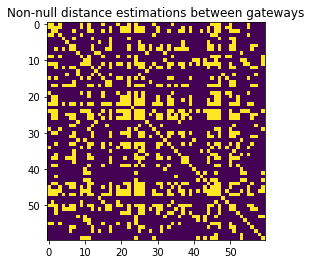

In [44]:
plt.title('Non-null distance estimations between gateways')
plt.imshow(med_time_diffs != -1, interpolation='nearest')
plt.show()

In [60]:
known_ids = [21, 25, 47]

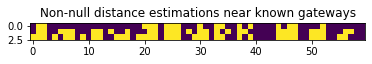

In [61]:
plt.title('Non-null distance estimations near known gateways')
plt.imshow((med_time_diffs != -1)[known_ids, :], interpolation='nearest')
plt.show()

In [63]:
print(med_time_diffs[known_ids, :][:, known_ids])

[[ 64.40016555 160.21285811 199.85051402]
 [160.21285811   8.4000217  223.9130218 ]
 [199.85051402 223.9130218   23.35692861]]


Cool, now that we have our relative sensors distances and selected three (kind of nice?) points for triangulation, we start to look at sensor ground truth data and see what we can do with that.

In [65]:
# Import the ground truth data.
truth_df = pd.read_csv('../smol_truth/sensors.csv')
truth_df.head()

,sensor ID,x (m),y (m),radius (m)
0,0,231.2663,120.1813,11.131326
1,1,371.8589,238.2076,11.634567
2,2,757.0289,350.5063,15.115731
3,3,190.9400,140.1613,13.697470
4,4,663.1340,522.3010,14.227241


In [70]:
true_dists = np.zeros((3, 3))
for i in range(len(known_ids)):
    for j in range(len(known_ids)):
        dist = np.linalg.norm((truth_df[['x (m)', 'y (m)']].iloc[known_ids[i]] - truth_df[['x (m)', 'y (m)']].iloc[known_ids[j]]))
        true_dists[[i,j], [j,i]] = dist

In [71]:
true_dists

array([[  0.        , 300.82918682, 215.23071766],
       [300.82918682,   0.        , 449.47345679],
       [215.23071766, 449.47345679,   0.        ]])

In [77]:
np.divide(true_dists, ave_time_diffs[known_ids, :][:, known_ids])

array([[0.        , 1.78931278, 1.11928977],
       [1.78931278, 0.        , 2.07113932],
       [1.11928977, 2.07113932, 0.        ]])

In [76]:
np.divide(true_dists, med_time_diffs[known_ids, :][:, known_ids])

array([[0.        , 1.87768442, 1.07695854],
       [1.87768442, 0.        , 2.00735738],
       [1.07695854, 2.00735738, 0.        ]])

In [100]:
np.divide(true_dists, dec_time_diffs[known_ids, :][:, known_ids])

array([[0.        , 2.76592063, 3.41635182],
       [2.76592063, 0.        , 2.81624249],
       [3.41635182, 2.81624249, 0.        ]])

In [88]:
np.divide(true_dists, min_time_diffs[known_ids, :][:, known_ids])

array([[0.        , 3.1368969 , 3.89204634],
       [3.1368969 , 0.        , 2.95900131],
       [3.89204634, 2.95900131, 0.        ]])

In [108]:
def get_ave_speed(speed_matrix):
    m, n = speed_matrix.shape
    if m != n :
        print("would be cooler if the matrix was square")
        return -1
    speeds = []
    for i in range(m-1):
        for j in range(i+1, n):
            speeds.append(speed_matrix[i, j])
    
    print(speeds)
    return np.mean(speeds)

In [112]:
get_ave_speed(np.divide(true_dists, ave_time_diffs[known_ids, :][:, known_ids]))

[1.7893127800493531, 1.119289771771533, 2.0711393152932405]


1.659913955704709

In [109]:
get_ave_speed(np.divide(true_dists, med_time_diffs[known_ids, :][:, known_ids]))

[1.8776844153712489, 1.076958539315376, 2.007357379986687]


1.6540001115577703

In [114]:
dec_speed = get_ave_speed(np.divide(true_dists, dec_time_diffs[known_ids, :][:, known_ids]))
print(dec_speed)

[2.765920631287047, 3.4163518222028, 2.816242486286258]
2.999504979925369


In [111]:
get_ave_speed(np.divide(true_dists, min_time_diffs[known_ids, :][:, known_ids]))

[3.1368968998844005, 3.8920463398014284, 2.959001310450001]


3.3293148500452765

In [107]:
x, y = np.divide(true_dists, med_time_diffs[known_ids, :][:, known_ids]).shape

In [80]:
ave_speed = np.mean([1.8777, 1.0770, 2.0074])
print(ave_speed)

1.6540333333333332


Ok, so the distances between the known gateways are more scuffed than I thought they would be, but I guess we get an average speed of 1.654 m/s between the three known locations. That's about on-brand for everything else.

Ah, after thinking about it a little, since we are doing direct paths, it would make more sense to take the shortest time between two points intead of the average or median time. I think minimum time is a little scuffed, so I take the 10th percentile time to use in our distance calculations instead. Average speed should work fine enough to convert from times to distances.

In [116]:
# Now we estimate our distance matrix
dec_dist_diffs = dec_time_diffs * dec_speed
print(dec_dist_diffs)

[[ 48.29215291 678.81971953  -2.99950498 ...  -2.99950498  -2.99950498
   -2.99950498]
 [678.81971953  46.19249572 337.62514984 ...  -2.99950498  -2.99950498
   -2.99950498]
 [ -2.99950498 337.62514984  23.76124653 ...  -2.99950498  -2.99950498
   -2.99950498]
 ...
 [ -2.99950498  -2.99950498  -2.99950498 ...  73.76626188  -2.99950498
   -2.99950498]
 [ -2.99950498  -2.99950498  -2.99950498 ...  -2.99950498  23.09624786
   -2.99950498]
 [ -2.99950498  -2.99950498  -2.99950498 ...  -2.99950498  -2.99950498
   23.09624786]]


Now we want to triangulate to find the next points. Here, I think I copy some of Tess's code.

In [121]:
# Construct our dictionary of "known" positions.
known = dict()
for known_id in known_ids:
    known[known_id] = truth_df[['x (m)','y (m)']].iloc[known_id].to_numpy()

print(known)

{21: array([670.0826, 296.305 ]), 25: array([724.8389, 592.1089]), 47: array([467.5076, 223.5889])}


In [150]:
# we will eventually use this thing I think.
dec_dist_from_known = None
dec_dist_from_guessed = None

In [149]:
def dist_err(point):
    errs = []
    for known_id in known:
        dec_dist = dec_dist_from_known[known_id]
        if dec_dist > 0:
            point_dist = np.linalg.norm(point - known[known_id])
            errs.append(point_dist - dec_dist)
    for guessed_id in guessed:
        dec_dist = dec_dist_from_guessed[guessed_id]
        if dec_dist > 0:
            point_dist = np.linalg.norm(point - guessed[guessed_id])
            errs.append(point_dist - dec_dist)
    return np.array(errs)

In [137]:
guessed = dict()
losses = []
for sensor_id in range(num_sensors):
    if sensor_id in known:
        continue
    dec_dist_from_known = dict()
    for known_id in known:
        if dec_dist_diffs[sensor_id, known_id] > 0:
            dec_dist_from_known[known_id] = dec_dist_diffs[sensor_id, known_id]
    if len(dec_dist_from_known) >= 3:
        print("Found three known points close to {}!".format(sensor_id))
        result = least_squares(dist_err, np.array([400,450]))
        losses.append([sensor_id, result.cost])
        guess_pos = result.x
        guessed[sensor_id] = guess_pos

Found three known points close to 1!
Found three known points close to 2!
Found three known points close to 22!
Found three known points close to 24!
Found three known points close to 26!
Found three known points close to 30!
Found three known points close to 33!
Found three known points close to 37!
Found three known points close to 44!
Found three known points close to 46!
Found three known points close to 52!


In [138]:
guessed

{1: array([160.89650944, 263.38316459]),
 2: array([672.59853124, 386.41696475]),
 22: array([502.1108603 , 227.58775407]),
 24: array([294.42095942, 266.72940866]),
 26: array([589.46745716, 368.34157771]),
 30: array([540.94507682, 553.14321071]),
 33: array([757.16341842, 269.11372819]),
 37: array([814.65486919, 554.99468243]),
 44: array([736.15615317, 490.42813884]),
 46: array([135.02230798, 307.7000514 ]),
 52: array([319.63129544, 604.49473434])}

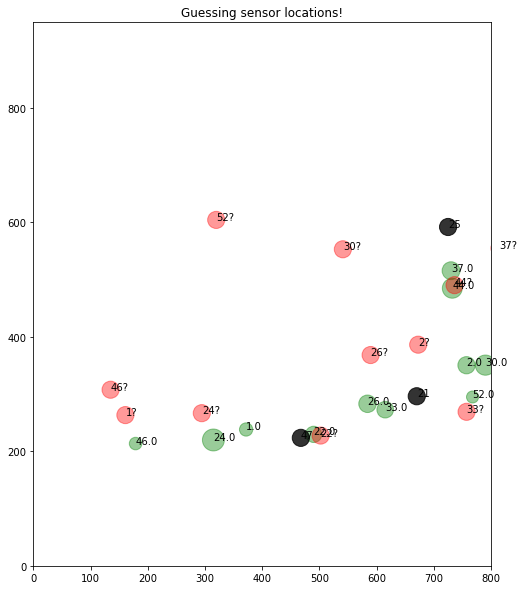

In [139]:
# Plot out our results and see how good they are.
plt.figure(figsize=(18,10))
plt.title("Guessing sensor locations!")
plt.xlim([0, 800])
plt.ylim([0, 950])
plt.gca().set_aspect("equal")

ax = plt.gcf().gca()
# Plot ground truth sensor positions.
for index, row in truth_df.iterrows():
    if index in guessed:
        ax.add_patch(plt.Circle((row['x (m)'], row['y (m)']), row['radius (m)'], alpha = 0.4, color='g'))
        plt.text(row['x (m)'], row['y (m)'], row['sensor ID'])
# Plot known sensor locations.
for index in known:
    ax.add_patch(plt.Circle(known[index], 15, alpha = 0.8, color='k'))
    plt.text(known[index][0], known[index][1], index)
# Plot guessed sensor locations.
for index in guessed:
    ax.add_patch(plt.Circle(guessed[index], 15, alpha=0.4, color='r'))
    plt.text(guessed[index][0], guessed[index][1], "{}?".format(index))

plt.show()

In [140]:
# Print out losses to see our "confidence" levels
losses

[[1, 86330.5522289007],
 [2, 64.09627842432062],
 [22, 205.04379962480877],
 [24, 6696.5885507573485],
 [26, 5513.192007412637],
 [30, 3.311318674534923],
 [33, 464.47353807338925],
 [37, 7321.059475587601],
 [44, 153.5238944990029],
 [46, 18933.81656332878],
 [52, 134130.868517707]]

In [147]:
# Try again with different loss function?
guessed = dict()
for sensor_id in range(num_sensors):
    if sensor_id in known:
        continue
    dec_dist_from_known = dict()
    for known_id in known:
        if dec_dist_diffs[sensor_id, known_id] > 0:
            dec_dist_from_known[known_id] = dec_dist_diffs[sensor_id, known_id]
    if len(dec_dist_from_known) >= 3:
        print("Found three known points close to {}!".format(sensor_id))
        guess_pos = least_squares(dist_err, np.array([600,400]), loss='soft_l1').x
        guessed[sensor_id] = guess_pos

Found three known points close to 1!
Found three known points close to 2!
Found three known points close to 22!
Found three known points close to 24!
Found three known points close to 26!
Found three known points close to 30!
Found three known points close to 33!
Found three known points close to 37!
Found three known points close to 44!
Found three known points close to 46!
Found three known points close to 52!


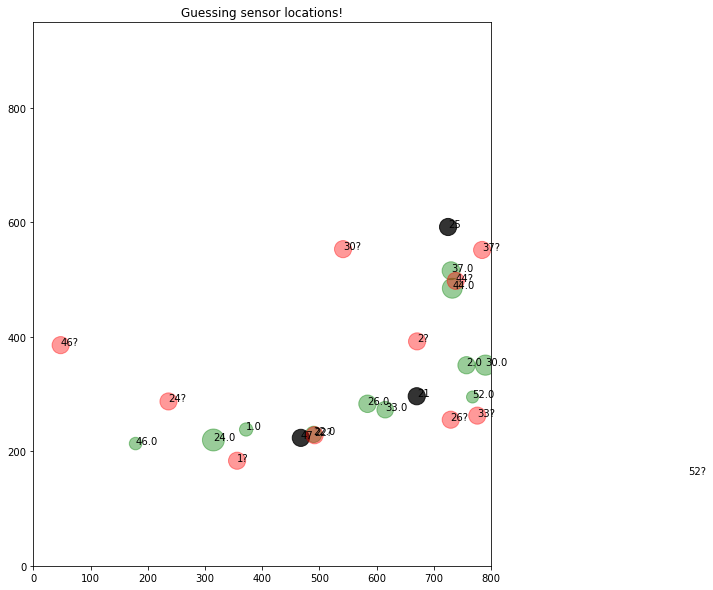

In [148]:
# Plot out our results and see how good they are.
plt.figure(figsize=(18,10))
plt.title("Guessing sensor locations!")
plt.xlim([0, 800])
plt.ylim([0, 950])
plt.gca().set_aspect("equal")

ax = plt.gcf().gca()
# Plot ground truth sensor positions.
for index, row in truth_df.iterrows():
    if index in guessed:
        ax.add_patch(plt.Circle((row['x (m)'], row['y (m)']), row['radius (m)'], alpha = 0.4, color='g'))
        plt.text(row['x (m)'], row['y (m)'], row['sensor ID'])
# Plot known sensor locations.
for index in known:
    ax.add_patch(plt.Circle(known[index], 15, alpha = 0.8, color='k'))
    plt.text(known[index][0], known[index][1], index)
# Plot guessed sensor locations.
for index in guessed:
    ax.add_patch(plt.Circle(guessed[index], 15, alpha=0.4, color='r'))
    plt.text(guessed[index][0], guessed[index][1], "{}?".format(index))

plt.show()

In [145]:
# Try again with different loss function?
guessed = dict()
for sensor_id in range(num_sensors):
    if sensor_id in known:
        continue
    dec_dist_from_known = dict()
    for known_id in known:
        if dec_dist_diffs[sensor_id, known_id] > 0:
            dec_dist_from_known[known_id] = dec_dist_diffs[sensor_id, known_id]
    if len(dec_dist_from_known) >= 3:
        print("Found three known points close to {}!".format(sensor_id))
        guess_pos = least_squares(dist_err, np.array([600,400]), loss='cauchy').x
        guessed[sensor_id] = guess_pos

Found three known points close to 1!
Found three known points close to 2!
Found three known points close to 22!
Found three known points close to 24!
Found three known points close to 26!
Found three known points close to 30!
Found three known points close to 33!
Found three known points close to 37!
Found three known points close to 44!
Found three known points close to 46!
Found three known points close to 52!


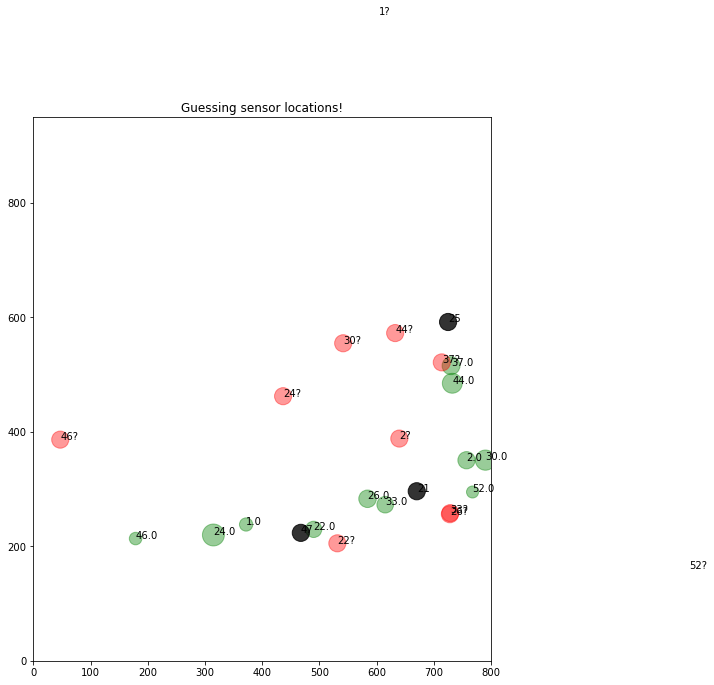

In [146]:
# Plot out our results and see how good they are.
plt.figure(figsize=(18,10))
plt.title("Guessing sensor locations!")
plt.xlim([0, 800])
plt.ylim([0, 950])
plt.gca().set_aspect("equal")

ax = plt.gcf().gca()
# Plot ground truth sensor positions.
for index, row in truth_df.iterrows():
    if index in guessed:
        ax.add_patch(plt.Circle((row['x (m)'], row['y (m)']), row['radius (m)'], alpha = 0.4, color='g'))
        plt.text(row['x (m)'], row['y (m)'], row['sensor ID'])
# Plot known sensor locations.
for index in known:
    ax.add_patch(plt.Circle(known[index], 15, alpha = 0.8, color='k'))
    plt.text(known[index][0], known[index][1], index)
# Plot guessed sensor locations.
for index in guessed:
    ax.add_patch(plt.Circle(guessed[index], 15, alpha=0.4, color='r'))
    plt.text(guessed[index][0], guessed[index][1], "{}?".format(index))

plt.show()

Ok, it seems like the code is somewhat functional. I want to see if we can iterate this a couple times with the new guesses to get them closer to each other?

In [163]:
for sensor_id in guessed:
    dec_dist_from_known = dict()
    dec_dist_from_guessed = dict()
    close_guesses = []
    for known_id in known:
        dec_dist_from_known[known_id] = dec_dist_diffs[sensor_id, known_id]
    for guessed_id in guessed:
        if sensor_id == guessed_id:
            dec_dist_from_guessed[guessed_id] = -1
        else:
            dec_dist_from_guessed[guessed_id] = dec_dist_diffs[sensor_id, guessed_id]
            if dec_dist_diffs[sensor_id, guessed_id] > 0:
                close_guesses.append(guessed_id)
    
    print("{} is close to guessed points {}!".format(sensor_id, close_guesses))
    guess_pos = least_squares(dist_err, guessed[sensor_id], loss='soft_l1').x
    guessed[sensor_id] = guess_pos

1 is close to guessed points [2, 22, 24, 26, 30, 37, 44, 46]!
2 is close to guessed points [1, 22, 24, 26, 30, 33, 37, 44, 46, 52]!
22 is close to guessed points [1, 2, 24, 26, 30, 33, 44, 46, 52]!
24 is close to guessed points [1, 2, 22, 26, 33, 37, 44, 46]!
26 is close to guessed points [1, 2, 22, 24, 30, 33, 37, 44, 46, 52]!
30 is close to guessed points [1, 2, 22, 26, 33, 37, 44, 52]!
33 is close to guessed points [2, 22, 24, 26, 30, 37, 44, 46, 52]!
37 is close to guessed points [1, 2, 24, 26, 30, 33, 44, 46, 52]!
44 is close to guessed points [1, 2, 22, 24, 26, 30, 33, 37, 46, 52]!
46 is close to guessed points [1, 2, 22, 24, 26, 33, 37, 44]!
52 is close to guessed points [2, 22, 26, 30, 33, 37, 44]!


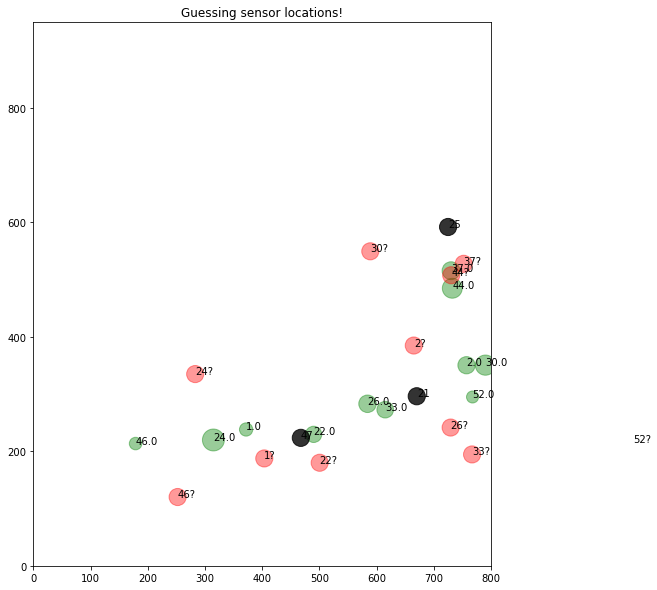

In [164]:
# Plot out our results and see how good they are.
plt.figure(figsize=(18,10))
plt.title("Guessing sensor locations!")
plt.xlim([0, 800])
plt.ylim([0, 950])
plt.gca().set_aspect("equal")

ax = plt.gcf().gca()
# Plot ground truth sensor positions.
for index, row in truth_df.iterrows():
    if index in guessed:
        ax.add_patch(plt.Circle((row['x (m)'], row['y (m)']), row['radius (m)'], alpha = 0.4, color='g'))
        plt.text(row['x (m)'], row['y (m)'], row['sensor ID'])
# Plot known sensor locations.
for index in known:
    ax.add_patch(plt.Circle(known[index], 15, alpha = 0.8, color='k'))
    plt.text(known[index][0], known[index][1], index)
# Plot guessed sensor locations.
for index in guessed:
    ax.add_patch(plt.Circle(guessed[index], 15, alpha=0.4, color='r'))
    plt.text(guessed[index][0], guessed[index][1], "{}?".format(index))

plt.show()

In [176]:
# Maybe try it with another loss?
for sensor_id in guessed:
    dec_dist_from_known = dict()
    dec_dist_from_guessed = dict()
    close_guesses = []
    for known_id in known:
        dec_dist_from_known[known_id] = dec_dist_diffs[sensor_id, known_id]
    for guessed_id in guessed:
        if sensor_id == guessed_id:
            dec_dist_from_guessed[guessed_id] = -1
        else:
            dec_dist_from_guessed[guessed_id] = dec_dist_diffs[sensor_id, guessed_id]
            if dec_dist_diffs[sensor_id, guessed_id] > 0:
                close_guesses.append(guessed_id)
    
    print("{} is close to guessed points {}!".format(sensor_id, close_guesses))
    guess_pos = least_squares(dist_err, guessed[sensor_id], loss='linear').x
    guessed[sensor_id] = guess_pos

1 is close to guessed points [2, 22, 24, 26, 30, 37, 44, 46]!
2 is close to guessed points [1, 22, 24, 26, 30, 33, 37, 44, 46, 52]!
22 is close to guessed points [1, 2, 24, 26, 30, 33, 44, 46, 52]!
24 is close to guessed points [1, 2, 22, 26, 33, 37, 44, 46]!
26 is close to guessed points [1, 2, 22, 24, 30, 33, 37, 44, 46, 52]!
30 is close to guessed points [1, 2, 22, 26, 33, 37, 44, 52]!
33 is close to guessed points [2, 22, 24, 26, 30, 37, 44, 46, 52]!
37 is close to guessed points [1, 2, 24, 26, 30, 33, 44, 46, 52]!
44 is close to guessed points [1, 2, 22, 24, 26, 30, 33, 37, 46, 52]!
46 is close to guessed points [1, 2, 22, 24, 26, 33, 37, 44]!
52 is close to guessed points [2, 22, 26, 30, 33, 37, 44]!


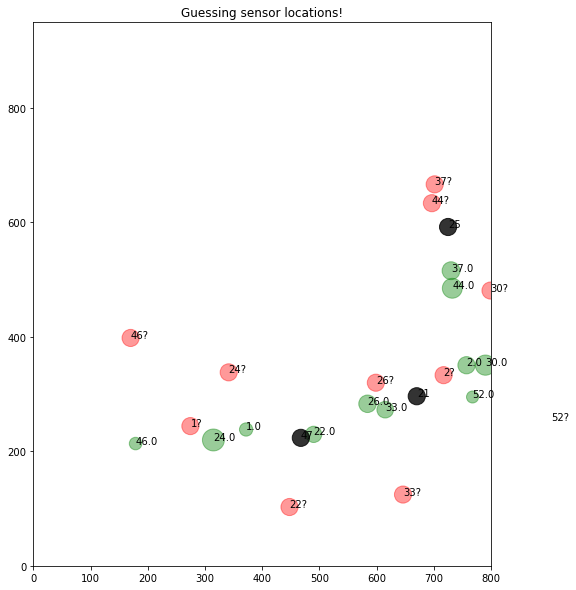

In [177]:
# Plot out our results and see how good they are.
plt.figure(figsize=(18,10))
plt.title("Guessing sensor locations!")
plt.xlim([0, 800])
plt.ylim([0, 950])
plt.gca().set_aspect("equal")

ax = plt.gcf().gca()
# Plot ground truth sensor positions.
for index, row in truth_df.iterrows():
    if index in guessed:
        ax.add_patch(plt.Circle((row['x (m)'], row['y (m)']), row['radius (m)'], alpha = 0.4, color='g'))
        plt.text(row['x (m)'], row['y (m)'], row['sensor ID'])
# Plot known sensor locations.
for index in known:
    ax.add_patch(plt.Circle(known[index], 15, alpha = 0.8, color='k'))
    plt.text(known[index][0], known[index][1], index)
# Plot guessed sensor locations.
for index in guessed:
    ax.add_patch(plt.Circle(guessed[index], 15, alpha=0.4, color='r'))
    plt.text(guessed[index][0], guessed[index][1], "{}?".format(index))

plt.show()

In [381]:
#function to check total time between gateways and returns average time
def gateway_total(gateway_x, gateway_y):
    count = 0
    time = 0
    size = backbone_sensor_df.shape[0]
    matrix = backbone_sensor_df.values
    
    hops = 3
    #TOD0: if the hops get too large we go out of range on the otherside. Fix this later
    
    for x in range(size):
        if (matrix[x][0] == gateway_x):
            #if it's the first indexes 
            if (x <= hops):
                for i in range(hops):
                    if (matrix[x+i][0] == gateway_y):
                        count += 1
                        time += abs(matrix[x+i][1] - matrix[x][1])
            
            #if it's in the last 5 index
            elif (x > size-hops):
                for i in range(hops):
                    if (matrix[x-i][0] == gateway_y):
                        count += 1
                        time += abs(matrix[x-i][1] - matrix[x][1])
            else:
                for i in range(hops):
                    #print(i)
                    #print(backbone_sensor_df.iloc[x+i][0])
                    #print(gateway_y)
                    if (matrix[x+i][0] == gateway_y):
                        count += 1
                        time += abs(matrix[x+i][1] - matrix[x][1])
                        #print('adding')
                    elif (matrix[x-i][0] == gateway_y):
                        count += 1
                        time += abs(matrix[x-i][1] - matrix[x][1])
                        #print('adding')
                       
                    
    if (count >= 1): 
        #print(count)
        return time/count
    else:
        return 0
        


In [382]:
#set up a matrix of time between adjacent gateways, this is a proxy for distance
num_gates = backbone_sensor_df['sensor ID'].nunique()
time_pairs = np.zeros((num_gates,num_gates))
gateway_ids = backbone_sensor_df['sensor ID'].drop_duplicates().values

for x in tqdm(range(num_gates)):
    #times = []
    for y in range(num_gates):
        #find how many times x gateway is adjacent to y gateway 
        gateway_id_x = gateway_ids[y]
        gateway_id_y = gateway_ids[x]
        average = gateway_total(gateway_id_x,gateway_id_y)

        #add to time_pairs[x][y]
        time_pairs[x][y] = average
        
        
time_pairs

100%|██████████| 60/60 [00:58<00:00,  1.02it/s]


array([[  2.24632004,   6.94112363, 164.96709107, ...,   0.        ,
          0.        ,   0.        ],
       [  6.60267399,   0.68333927,  48.44846901, ...,   0.        ,
         53.90013867,   0.        ],
       [164.96709107,  47.9981627 ,   1.30367065, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  13.31798298,
          0.        ,   0.        ],
       [  0.        ,  53.90013867,   0.        , ...,   0.        ,
          0.69400179,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   6.77548913]])

In [368]:
#get the average velocity from the ground truth data 
avg_vel = 2 #m/s

In [370]:
#calculate the distance matrix from the average time and average velocity 
distance = avg_vel*time_pairs
distance
print(distance.shape)

(60, 60)


In [371]:
#pick three gateways to triangulate from ground truth
gateway_a = [231.2663,120.1813]
gateway_b = [197.9663,793.9513]
gateway_c = [757.0289,350.5063]

x1 = gateway_a[0]
y1 = gateway_a[1]

x2 = gateway_b[0]
y2 = gateway_b[1]

x3 = gateway_c[0]
y3 = gateway_c[1]



In [388]:
#function to return the distance error between points
def distance_err(point):
    x = point[0]
    y = point[1]
    error1 = np.abs(np.linalg.norm(np.array([x,y])-np.array([x1,y1])) - d1)**2
    error2 = np.abs(np.linalg.norm(np.array([x,y])-np.array([x2,y2])) - d2)**2
    error3 = np.abs(np.linalg.norm(np.array([x,y])-np.array([x3,y3])) - d3)**2
    error_total = error1 + error2 + error3
    
    return error_total 

#Example use of 
#least_squares(fun,[16000,25000])

In [389]:
#for each gateway get the location 
positions_x = []
positions_y = []

#loop through gateways 
for i in range(len(gateway_ids)):
    gateway = gateway_ids[i]
    d1 = distance[i][0]
    d2 = distance[i][1]
    d3 = distance[i][2]
    
    positions_x.append(least_squares(distance_err,[400,400]).x[0])
    positions_y.append(least_squares(distance_err,[400,400]).x[1])

zipped = list(zip(gateway_ids,positions_x,positions_y))
positions = pd.DataFrame(zipped, columns = ['gateway_ids','positions_x','positions_y'])
positions.head()

,gateway_ids,positions_x,positions_y
0,15,288.766748,438.947391
1,34,365.726884,431.743723
2,19,477.195367,489.940492
3,49,468.446493,436.936218
4,9,273.577663,687.215509


In [390]:
##Import the excel file 
truth_df = pd.read_csv('sensors.csv')
truth_df.head()

gateway_ids

#get the ground truth values for the gateway ids of interest
truth_df_filtered = truth_df[truth_df['sensor ID'].isin(gateway_ids)]
truth_df_filtered.head()

,sensor ID,x (m),y (m),radius (m)
0,0,231.2663,120.1813,11.131326
1,1,371.8589,238.2076,11.634567
2,2,757.0289,350.5063,15.115731
3,3,190.9400,140.1613,13.697470
4,4,663.1340,522.3010,14.227241


In [391]:
#get gateway_id position error 

error = np.zeros(60)
for i in range(len(gateway_ids)):
    gateway = gateway_ids[i]
    truth_data = truth_df[truth_df['sensor ID'] == gateway]
    x = truth_data['x (m)'].values
    y = truth_data['y (m)'].values
    
    position_data = positions[positions['gateway_ids'] == gateway]
    x_est = position_data['positions_x'].values
    y_est = position_data['positions_y'].values
    
    error[i] = np.linalg.norm(np.array([x,y])-np.array([x_est,y_est]))
    
print(error)

[ 506.48593724  436.19933622  425.35286542  373.92221028  529.85142804
   75.29682372  886.82064735  291.12794261  883.14283962  851.00803066
  397.75366345  422.501899    476.51514903  286.0455173   885.63779095
 1033.56334858  155.50285749 1127.50969947  516.49906479  150.19874471
  308.6928298   281.31118212  266.9975758   304.49295699  278.84686746
  295.68881408  241.16626988  370.95566389  347.5987952   342.68246818
  368.52040651  401.03900499  788.67889863  386.18554012  337.95639409
  717.21515679  400.16271205  490.5812728   882.24249563  372.43550633
  526.1056056   414.3297827   380.74633105  381.14937091  418.38914767
  342.00126719  352.811711    438.0515301   693.98591332  421.51361164
  410.52512583  333.52000815  332.28808082  381.70401895  196.55742951
  558.77988037  207.89825182  529.95698031  251.3629782   437.062473  ]


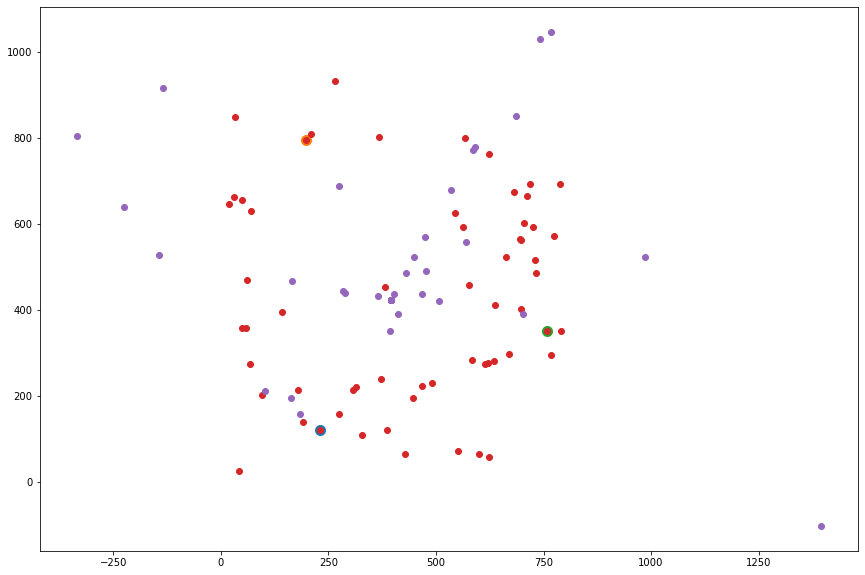

In [392]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
plt.scatter(x1,y1,s=100,marker='o')
plt.scatter(x2,y2,s=100,marker='o')
plt.scatter(x3,y3,s=100,marker='o')
plt.scatter(truth_df_filtered["x (m)"], truth_df_filtered["y (m)"])
plt.scatter(positions['positions_x'], positions['positions_y'])
plt.show()

In [ ]:
#bring in other sensor traces 
#figure out your for loopin problem 

In [ ]:
#Unused function to check how many times gateways are next to each other and return average time 
def gateway_adjacent(gateway_x, gateway_y):
    #print(gateway_x)
    #print(gateway_y)
    
    count = 0
    time = 0
    size = backbone_sensor_df.shape[0]
    #print(size)
    for x in range(size):
        if (backbone_sensor_df.iloc[x][0] == gateway_x):
            #if it's the first index 
            if (x == 0):
                if (backbone_sensor_df.iloc[x+1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+1][1] - backbone_sensor_df.iloc[x][1])
            
            #if it's a last index
            elif (x == size-1):
                if (backbone_sensor_df.iloc[x-1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-1][1] - backbone_sensor_df.iloc[x][1])
            
            else:
                if (backbone_sensor_df.iloc[x+1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+1][1] - backbone_sensor_df.iloc[x][1])
                elif (backbone_sensor_df.iloc[x-1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-1][1] - backbone_sensor_df.iloc[x][1])
                    
    if (count >= 1): 
        return time/count
    else:
        return 0

In [ ]:
#filter to adjadent gateways with a time difference larger than 3 seconds

#take this out? Can we just use the smol attack data directly

#diff_sensor_df = sensor_df_smol.diff()
#print(diff_sensor_df[40:60])
#print(sensor_df_smol[40:60])
#[diff_sensor_df['norm_secs (secs)'] > 5]

#backbone_sensor_df = sensor_df_smol 
#backbone_sensor_df.head()